In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import re
import contractions
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/phoenix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/phoenix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/phoenix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
df = pd.read_csv('reply_classification_dataset.csv')
df.head()

,reply,label
0,Can we discuss pricing??,NEUTRAL
1,"Im excited to explore this further, plz send c...",POSITIVE
2,We not looking for new solutions.,negative
3,Could u clarify features included?,neutral
4,"lets,, schedule a meeting to dive deeper",positive


In [39]:
df['label'].unique()

array(['NEUTRAL', 'POSITIVE', 'negative', 'neutral', 'positive',
       'NEGATIVE', 'Positive', 'Neutral', 'Negative'], dtype=object)

In [40]:
def func(label):
    if label in ['NEUTRAL', 'neutral', 'Neutral']:
        return 'neutral'
    elif label in ['POSITIVE', 'positive', 'Positive']:
        return 'positive'
    else:
        return 'negative'

In [41]:
df['label'] = df['label'].apply(func)
print(df['label'].unique())

['neutral' 'positive' 'negative']


In [42]:
df.head()

,reply,label
0,Can we discuss pricing??,neutral
1,"Im excited to explore this further, plz send c...",positive
2,We not looking for new solutions.,negative
3,Could u clarify features included?,neutral
4,"lets,, schedule a meeting to dive deeper",positive


In [43]:
df.isna().sum()

reply    0
label    0
dtype: int64

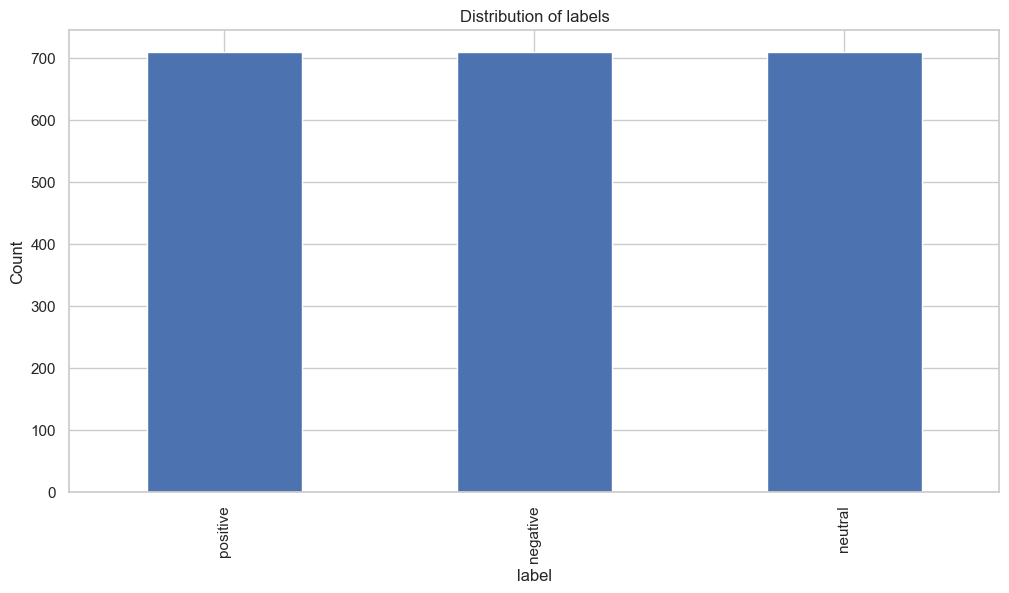

In [44]:
# Plotting the distribution of labels

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
df['label'].value_counts().plot(kind = 'bar')
plt.title('Distribution of labels')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [45]:
df.shape

(2129, 2)

In [47]:
# Preprocessing for classic ML models

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_classic(text):
    """Preprocess the text by removing non-letters, converting to lowercase,
    expanding contractions, removing stop words, and lemmatizing."""
    
    # Lowercase
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # Tokenize
    words = word_tokenize(text)
    
    # Lemmatize + remove stopwords
    cleaned_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    
    return " ".join(cleaned_words)


In [48]:
df['reply_clean'] = df['reply'].apply(preprocess_classic)

In [49]:
df.head()

,reply,label,reply_clean
0,Can we discuss pricing??,neutral,discus pricing
1,"Im excited to explore this further, plz send c...",positive,excited explore plz send contract
2,We not looking for new solutions.,negative,looking new solution
3,Could u clarify features included?,neutral,could clarify feature included
4,"lets,, schedule a meeting to dive deeper",positive,let u schedule meeting dive deeper


In [50]:
# Initialize encoder
le = LabelEncoder()

# Fit on labels and transform
y = le.fit_transform(df['label'])

print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Classes mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [51]:
# 3. Save encoder for later use
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [52]:
df['label_encoded'] = y

In [53]:
df.head()

,reply,label,reply_clean,label_encoded
0,Can we discuss pricing??,neutral,discus pricing,1
1,"Im excited to explore this further, plz send c...",positive,excited explore plz send contract,2
2,We not looking for new solutions.,negative,looking new solution,0
3,Could u clarify features included?,neutral,could clarify feature included,1
4,"lets,, schedule a meeting to dive deeper",positive,let u schedule meeting dive deeper,2


In [54]:
X = df['reply_clean']
y = df['label_encoded']

In [55]:
# 1. Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [56]:
def vectorize_train_test(X_train, X_test, method='tfidf'):
    if method == 'bow':
        vectorizer = CountVectorizer()
    elif method == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Method must be either 'bow' or 'tfidf'")
    
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec, vectorizer


In [57]:
# TF-IDF
X_train_vec, X_test_vec, vec = vectorize_train_test(X_train, X_test, method='tfidf')